In [1]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as scipystats
from matplotlib.pyplot import figure

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs
from analysis.adapters.hdf5 import H5NAMES

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [4]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
bad_clu_dir = '/home/andrey/storage2/andrey/data/projects/24_shift/bad_clusters'
#bad_clu_dir = '/storage2/andrey/data/projects/24_shift/bad_clusters'

assets = '/home/andrey/storage2/andrey/data/projects/24_shift/assets'
paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
#paper = '/storage2/andrey/data/projects/24_shift/paper'
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364'] # '002784', 

s_list_bl = get_sessions_list(source, animals, 'SHIFT both')
s_list_bd = get_sessions_list(source, animals, 'SHIFT both +dark')

sessions_list = list(s_list_bl) + list(s_list_bd)
sessions_list

[['003281', '2019-11-18_22-10-40', 'SHIFT both'],
 ['003282', '2019-11-18_21-48-32', 'SHIFT both'],
 ['003282', '2019-11-28_15-28-59', 'SHIFT both'],
 ['003282', '2019-12-03_10-36-38', 'SHIFT both'],
 ['003282', '2019-12-05_10-04-14', 'SHIFT both'],
 ['003908', '2020-03-28_18-06-58', 'SHIFT both +dark'],
 ['003908', '2020-04-08_11-39-51', 'SHIFT both +dark'],
 ['003908', '2020-05-05_18-10-25', 'SHIFT both +dark'],
 ['003909', '2020-03-28_18-36-22', 'SHIFT both +dark'],
 ['005363', '2020-10-24_16-50-38', 'SHIFT both +dark'],
 ['005363', '2020-10-27_09-46-06', 'SHIFT both +dark'],
 ['005364', '2020-10-24_17-32-52', 'SHIFT both +dark']]

In [5]:
# or a single session
# sessions = [
#     ['003282', '2019-11-06_22-36-07', 'GAIN 3 parts'],
#     ['003282', '2019-11-18_10-35-43', 'GAIN 3 parts'],
# ]

shift_A_B_all = get_fields_between_epochs(source, sessions_list, 'A', 'B')
shift_A_B = get_fields_between_epochs(source, s_list_bd, 'A', 'B')
shift_A_Ad = get_fields_between_epochs(source, sessions_list, 'A', 'Ad')
shift_B_Ad = get_fields_between_epochs(source, sessions_list, 'B', 'Ad')
shift_B_Bd = get_fields_between_epochs(source, sessions_list, 'B', 'Bd')
shift_Ad_Bd = get_fields_between_epochs(source, sessions_list, 'Ad', 'Bd')

PF match found for 205 fields from total 408 A and 402 B fields
PF match found for 106 fields from total 194 A and 200 B fields
PF match found for 107 fields from total 194 A and 193 Ad fields
PF match found for 102 fields from total 200 B and 193 Ad fields
PF match found for 115 fields from total 200 B and 173 Bd fields
PF match found for 104 fields from total 193 Ad and 173 Bd fields


In [6]:
print(list(shift_A_B))

['animal', 'session', 'electrode', 'unit', 'field_A', 'field_B', 'overlap_norm', 'sic_A', 'sic_B', 'isol_dist', 'peak_FR_A', 'peak_FR_B', 'COMa_x', 'COMa_y', 'COMb_x', 'COMb_y', 'shift', 'size_A', 'size_B']


# Filters

## Bad fields

- information content > 0.2
- peak firing rate > 1.5Hz
- isolation distance > 15

In [7]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [8]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

## Split in groups by shift range

In [9]:
def get_idxs_by_shift_range(dataset, shift_min, shift_max):
    return (dataset['shift'] > shift_min) & (dataset['shift'] < shift_max)

# ANALYSIS

## Examples of cells

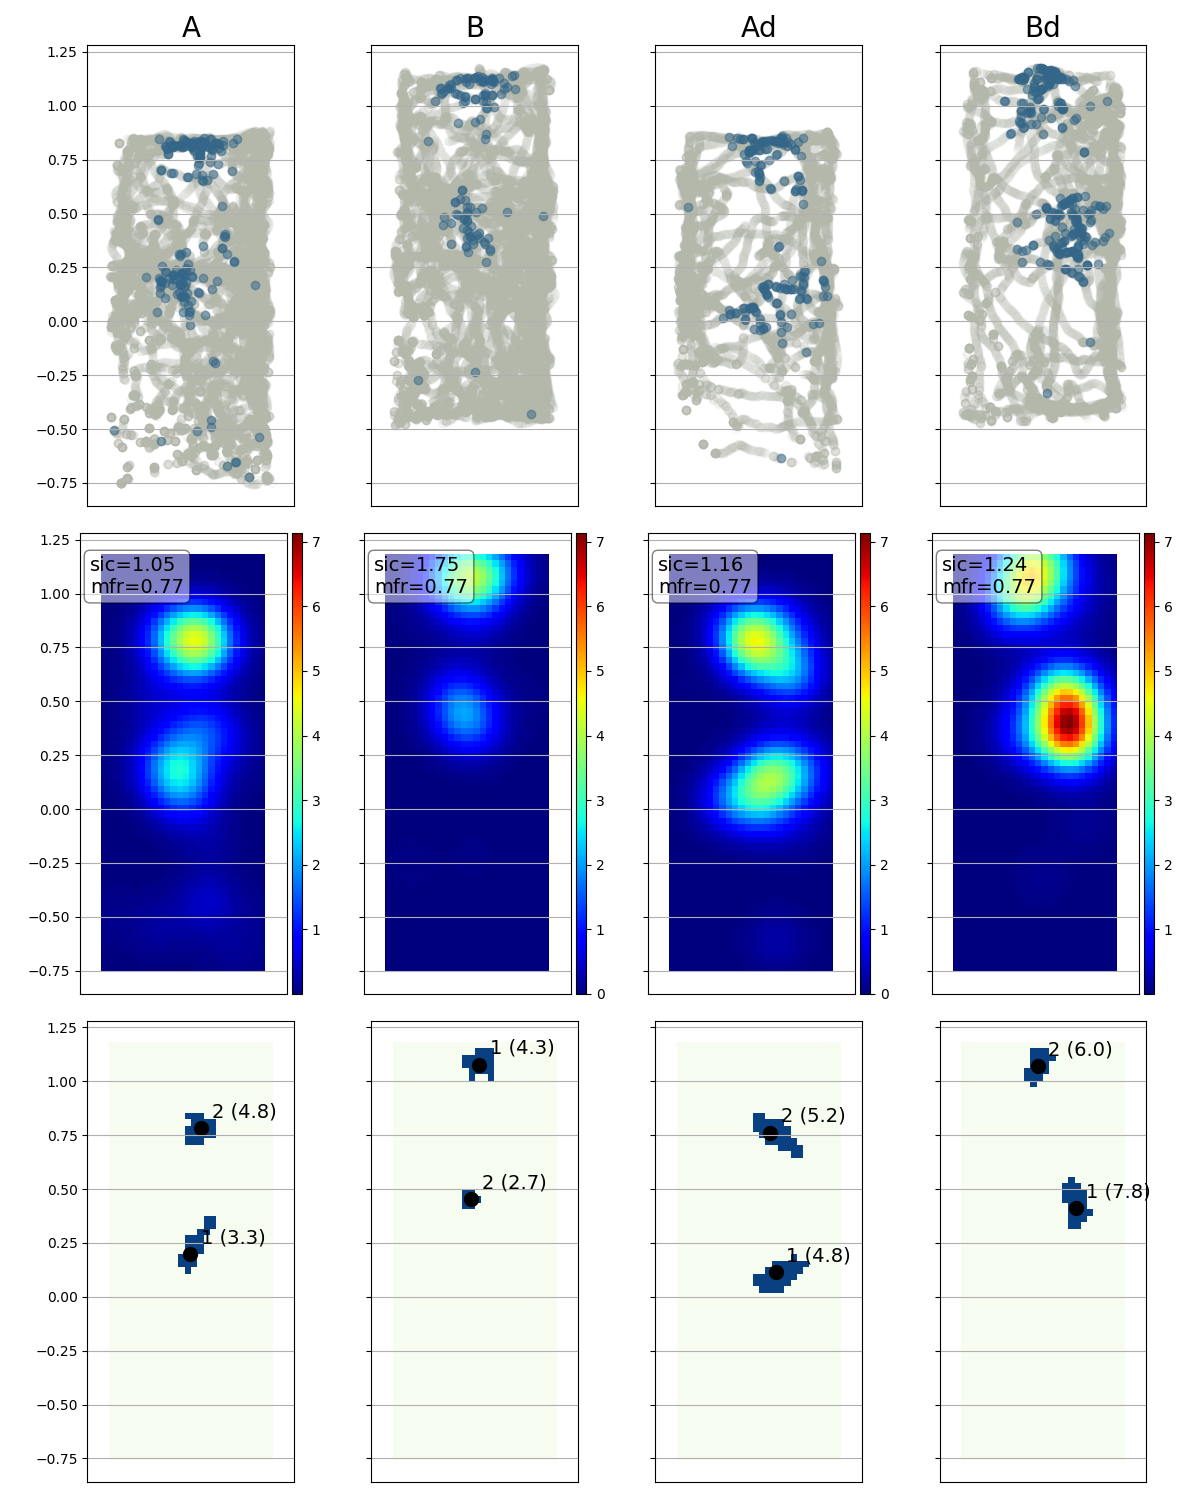

In [54]:
from IPython.display import Image

example_animal = '005363'
example_session = '2020-10-27_09-46-06'
example_unit = '2_4'
# 1_2, 2_4 : nice 1- or 2-field cells
# 2_10 : 2-field cell with one field stable, one field totally disappears

example = os.path.join(source, example_animal, example_session, 'analysis', 'bootstrapped', \
                       '%s_%s_%s.png' % (example_animal, example_session, example_unit))
Image(filename = example, width=600)

In [18]:
# explore shift > 0.2
dfl = shift_A_B_all.copy()
dfl['shift'] = (-1) * (dfl['shift'] - 0.3)

dfl = dfl[get_idxs_of_good_clu(dfl)]
dfl = dfl[get_idxs_by_quality(dfl)]

dfl[dfl['shift'] > 0.2]

animal              session  electrode  unit  field_A  field_B  \
48  003282  2019-11-18_21-48-32          7     3      1.0      2.0   

    overlap_norm     sic_A     sic_B  isol_dist  peak_FR_A  peak_FR_B  \
48      0.229508  0.953725  0.710775  29.041303      3.639       2.78   

      COMa_x    COMa_y    COMb_x    COMb_y     shift  size_A  size_B  
48 -0.138439  0.511583 -0.226488  0.596094  0.215489      21      40

In [19]:
dfd = shift_Ad_Bd.copy()
dfd['shift'] = (-1) * (dfd['shift'] - 0.3)

dfd = dfd[get_idxs_of_good_clu(dfd)]
dfd = dfd[get_idxs_by_quality(dfd)]

dfd[dfd['shift'] > 0.2]

Empty DataFrame
Columns: [animal, session, electrode, unit, field_A, field_B, overlap_norm, sic_A, sic_B, isol_dist, peak_FR_A, peak_FR_B, COMa_x, COMa_y, COMb_x, COMb_y, shift, size_A, size_B]
Index: []

### Place fields ignore possible global distal cues and encode proximal space inside the arena

In [51]:
np.array(((dfl['size_A'] + dfl['size_B'])/2)).mean()
np.array(dfl['size_A']).mean()
np.array(dfl['size_B']).mean()

36.88073394495413

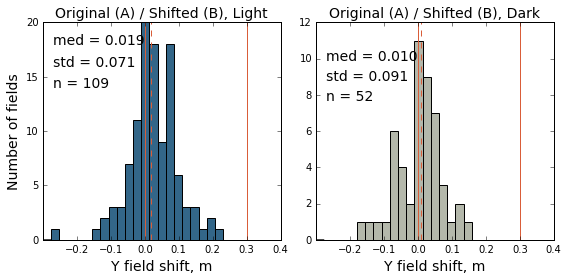

In [12]:
dfl = shift_A_B_all.copy()
dfl['shift'] = (-1) * (dfl['shift'] - 0.3)

dfl = dfl[get_idxs_of_good_clu(dfl)]
dfl = dfl[get_idxs_by_quality(dfl)]

# normalized by size
f_size_mean = np.array(((dfl['size_A'] + dfl['size_B'])/2)).mean()
data_norm = f_size_mean * dfl['shift'] / ((dfl['size_A'] + dfl['size_B'])/2)
# just shift
data_l = dfl['shift']

# mean, std, etc
med = np.median(data_l)
std = np.std(data_l)
bins = np.linspace(-0.3, 0.4, 30)
y_max = np.histogram(data_l, bins)[0].max()
#t_stat, p_value = scipystats.ttest_1samp(data, 0.3)  # FIXME do kruskal-wallis

dummy = np.zeros(len(data_l))
t_stat, p_value = scipystats.kruskal(data_l, dummy)

# histogram of COM shifts - Light
fig = figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.set_xlim(-0.3, 0.4)
ax.hist(data_l, bins, color=COLORS['a'], ec='black')
ax.axvline(0, color=COLORS['b'])
ax.axvline(0.3, color=COLORS['b'])
ax.axvline(med, ls='--', color=COLORS['b'])
ax.set_xlabel('Y field shift, m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(-0.27, 0.9 * y_max, 'med = %.3f' % med, fontsize=14)
ax.text(-0.27, 0.8 * y_max, 'std = %.3f' % std, fontsize=14)
ax.text(-0.27, 0.7 * y_max, 'n = %d' % len(data_l), fontsize=14)
#ax.text(-0.17, 0.6 * y_max, 'p < %.3f' % p_value, fontsize=14)
ax.set_title('Original (A) / Shifted (B), Light', fontsize=14)


# histogram of COM shifts - Dark
dfd = shift_Ad_Bd.copy()
dfd['shift'] = (-1) * (dfd['shift'] - 0.3)

#idxs = get_idxs_by_quality(shift_Ad_Bd)
#data = -1 * (np.array(shift_Ad_Bd[idxs]['shift']) - 0.3)
dfd = dfd[get_idxs_of_good_clu(dfd)]
data = dfd[get_idxs_by_quality(dfd)]['shift']

med = np.median(data)
std = np.std(data)
y_max = np.histogram(data, bins)[0].max()

dummy = np.zeros(len(data)) + 0.3
t_stat, p_value = scipystats.kruskal(data, dummy)

ax = fig.add_subplot(122)
ax.set_xlim(-0.3, 0.4)
ax.hist(data, bins, color=COLORS['f'], ec='black')
ax.axvline(0, color=COLORS['b'])
ax.axvline(0.3, color=COLORS['b'])
ax.axvline(med, ls='--', color=COLORS['b'])
ax.set_xlabel('Y field shift, m', fontsize=14)
ax.text(-0.27, 0.9 * y_max, 'med = %.3f' % med, fontsize=14)
ax.text(-0.27, 0.8 * y_max, 'std = %.3f' % std, fontsize=14)
ax.text(-0.27, 0.7 * y_max, 'n = %d' % len(data), fontsize=14)
#ax.text(-0.17, 0.6 * y_max, 'p < %.3f' % p_value, fontsize=14)
ax.set_title('Original (A) / Shifted (B), Dark', fontsize=14)


fig.tight_layout()
filename = "E_2c.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

In [64]:
np.percentile(data_norm, 90)

0.10868672112906816

In [74]:
# Number of neurons involved
idxs = get_idxs_by_quality(shift_A_B_all)
un_l = [x['session'] + str(x['electrode']) + str(x['unit']) for i, x in shift_A_B_all[idxs].iterrows()]
idxs = get_idxs_by_quality(shift_Ad_Bd)
un_d = [x['session'] + str(x['electrode']) + str(x['unit']) for i, x in shift_Ad_Bd[idxs].iterrows()]

len(set(un_l)), len(set(un_d))

(110, 56)

### Supplementary 1: vestibular effects

In [28]:
# vestibular effects? test against arena move (also separately in dark)
shifts = []  # pairs of field shift, arena shift

data = shift_A_B_all.copy()
data = shift_Ad_Bd.copy()

idxs = get_idxs_by_quality(data)
for i, row in data[idxs].iterrows():
    h5_path = os.path.join(source, row['animal'], row['session'], '%s.h5' % H5NAMES.filebase)
    
    with h5py.File(h5_path, 'r') as f:
        arena_traj = np.array(f['arena_trajectory'])
        arena_min = arena_traj[:, 2].min()
        arena_max = arena_traj[:, 2].max()
        arena_shift = arena_max - arena_min
        
    shifts.append([float(row['shift']), arena_shift])
        
shifts = np.array(shifts)

st, pv = scipystats.ttest_ind(shifts[:, 0], shifts[:, 1])
st, pv = scipystats.kruskal(shifts[:, 0], shifts[:, 1])
st, pv

(16.1797021719974, 5.760810274087116e-05)

### Fields keep their location after removing of visual reference frame in dark

In [13]:
def get_match_idxs(dataset, row):
    idxs_1 = (dataset['session'] == row['session'])
    idxs_2 = (dataset['electrode'] == row['electrode'])
    idxs_3 = (dataset['unit'] == row['unit'])
    idxs_4 = (dataset['field_A'] == row['field_A'])
    return idxs_1 & idxs_2 & idxs_3 & idxs_4

In [14]:
# match stats
match_both = []
match_A_Ad = []
match_B_Bd = []
match_none = []

# field pairs A-B filtered by quality
sf_A_B = shift_A_B[get_idxs_of_good_clu(shift_A_B)]
sf_A_B = sf_A_B[get_idxs_by_quality(sf_A_B)]

data = dfl[get_idxs_by_quality(dfl)]['shift']

# for each matched pair in light (A, B) search for pair in dark (A, Ad and B, Bd)
for i, row in sf_A_B.iterrows():
    idxs_A = get_match_idxs(shift_A_Ad, row)
    idxs_B = get_match_idxs(shift_B_Bd, row)
    
    if idxs_A.any() and idxs_B.any():
        match_both.append(row.name)
    elif idxs_A.any():
        match_A_Ad.append(row.name)
    elif idxs_B.any():
        match_B_Bd.append(row.name)
    else:
        match_none.append(row.name)

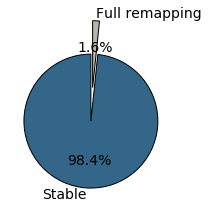

In [18]:
data = [len(match_both) + len(match_A_Ad) + len(match_B_Bd), len(match_none)]
labels = 'Stable', 'Full remapping'
colors = [COLORS['a'], COLORS['f']]
explode = (0, 0.5)

fig = figure(figsize=(3, 3))
ax = fig.add_subplot(111)

wedges, labels, autopct = ax.pie(data, explode=explode, colors=colors, labels=labels, \
             autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
for lab in labels:
    lab.set_fontsize(14)

#fig.tight_layout()    
filename = "E_2d.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### Field size - ?

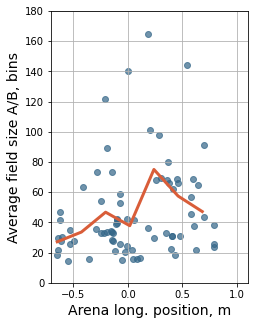

In [59]:
fig = figure(figsize=(12, 5))
st_bins = 7

idxs = get_idxs_by_quality(shift_A_B)
pos = (np.array(shift_A_B[idxs]['COMa_y']) + np.array(shift_A_B[idxs]['COMb_y'])) / 2
sizes = (np.array(shift_A_B[idxs]['size_A']) + np.array(shift_A_B[idxs]['size_B'])) / 2

# scatter of fields
ax = fig.add_subplot(131)
ax.set_xlim(-0.7, 1.1)
ax.set_ylim(0, 180)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('Average field size A/B, bins', fontsize=14)
ax.scatter(pos, sizes, alpha=0.7, color=COLORS['a'], label='Original')
ax.grid()

# binned statistic
st, edges, bin_no = scipystats.binned_statistic(pos, sizes, bins=st_bins)
x_vals = np.array(edges[:-1]) + np.abs((edges[1] - edges[0]))/2
ax.plot(x_vals, st, linewidth=3, color=COLORS['b'])